# Params

**Imports**

In [1]:
#pip install tqdm

In [1]:
#pip install torchvision

In [2]:
#pip install opencv-python

In [1]:
#pip install astropy

In [2]:
#pip install matplotlib

In [3]:
#pip install dill

In [1]:
#Download
     #tqdm
     #torchvision
     #cv2   
#Pytorch dataset 
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from astropy.io import fits
import numpy as np
import random

#Deep Learning
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import save_image
#images#
import cv2
import os
from matplotlib import pyplot as plt

#sesion save# 
import dill

#
from datasetImages import DatasetImages
from datasetDirty import DatasetDirty
import cupy as cp
cp.cuda.Device(1).use()
# Drive
#from google.colab import drive
#drive.mount('/content/drive')

**Params Images**

In [2]:
N = 28 # image size
N_PSF = 28 # psf size
TYPE_PSF = 'psf_gauss_'+str(N)+'x'+str(N)

**Params Dataset Python**


In [3]:
PATH_IMAGES = '../datasets/images_'+str(N)+'x'+str(N)+'/images' #path dataset images
PATH_CONVOLUTION = '../datasets/images_'+str(N)+'x'+str(N)+'/convolutions/'+TYPE_PSF+'/conv'#path dataset convolution
PATH_PSF_SAVE =  '../datasets/images_'+str(N)+'x'+str(N)+'/convolutions/'+TYPE_PSF+'/psf'#path convolution
INITIAL_DATASET = 0  #initial index for the names of the saved images 
FINAL_DATASET =  200000#final index for the names of the saved images 
PERC_TRAIN = 0.7 # (70%) #train percentage 
PERC_VAL = 0.25 #  (25#) #validation percentage
PERC_TEST =  0.05 # (5%) #test percentag

BATCH_TRAIN = 100
BATCH_VALIDATION = 100 #batch sizeimages
BATCH_TEST = 1

**Params Dataset Python**


In [4]:
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
size_data= FINAL_DATASET - INITIAL_DATASET
PATH_VALIDATION =  '../datasets/images_'+str(N)+'x'+str(N)+'/convolutions/'+TYPE_PSF+'/models/model_S'+str(size_data)+'_B'+str(BATCH_TRAIN)+'_N'+str(NUM_EPOCHS)+'/validation'
PATH_TEST =  '../datasets/images_'+str(N)+'x'+str(N)+'/convolutions/'+TYPE_PSF+'/models/model_S'+str(size_data)+'_B'+str(BATCH_TRAIN)+'_N'+str(NUM_EPOCHS)+'/test'
PATH_GRAPH ='../datasets/images_'+str(N)+'x'+str(N)+'/convolutions/'+TYPE_PSF+'/models/model_S'+str(size_data)+'_B'+str(BATCH_TRAIN)+'_N'+str(NUM_EPOCHS)+'/graph'
PATH_MODEL_SAVE ='../datasets/images_'+str(N)+'x'+str(N)+'/convolutions/'+TYPE_PSF+'/models/model_S'+str(size_data)+'_B'+str(BATCH_TRAIN)+'_N'+str(NUM_EPOCHS)+'/model' #path where the dataset convolution is saved


**Auxiliary functions**

TODO: comentar

In [5]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, N, N)
    save_image(img, name)
    
def make_dir(path):
        if not os.path.exists(path):
            os.makedirs(path)


TODO: comentar

In [6]:
def display_two(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display one image
def display(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.show()

display fit image from a directory

# Pytorch Dataset

**Params**

In [7]:
size = FINAL_DATASET- INITIAL_DATASET  #size of lot of the dataset
size_train = round(size*PERC_TRAIN)
size_validation =  round(size*PERC_VAL)
size_test =  round(size*PERC_TEST)  
batch_train_size=  BATCH_TRAIN 
batch_test_size=  BATCH_TEST
batch_validation_size=  BATCH_VALIDATION
data_image = DatasetImages(N)
data_image = data_image.read(size_image=N, start = INITIAL_DATASET,stop = FINAL_DATASET)
data_dirty = DatasetDirty(N,TYPE_PSF)
data_dirty=data_dirty.read(size_image = N, type_psf = TYPE_PSF,start = INITIAL_DATASET, stop = FINAL_DATASET)

KeyboardInterrupt: 

TODO: Comentar como en tutorial (DATAset create)

In [9]:
print("finalized")

finalized


In [27]:
class interferometryDataset(Dataset):
  def __init__(self,datasetnoised,datasetclean,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    self.transform=transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    
    if self.transform != None:
      xNoise=self.transform(cp.asnumpy(xNoise))
      xClean=self.transform(cp.asnumpy(xClean))

    return (xNoise,xClean)

we define the transforms for the images of dataset.

In [28]:
tsfms=transforms.Compose([
    transforms.ToTensor()
])

we divide the images into training and test sets

In [29]:
train_dirty = data_dirty[0:size_train]
train_images = data_image[0:size_train]

validation_dirty = data_dirty[size_train:size_train+size_validation]
validation_image = data_image[size_train:size_train+size_validation]


test_dirty = data_dirty[size_validation:size_validation+size_test]
test_image = data_image[size_validation:size_validation+size_test]

we generate the dataset using `Dataloard` that eases the task of making iterable training and testing sets. 

In [30]:
trainSet=interferometryDataset(train_dirty,train_images,tsfms)
validationSet = interferometryDataset(validation_dirty,validation_image,tsfms)
testSet=interferometryDataset(test_dirty,test_image,tsfms)


trainLoader=DataLoader(trainSet,batch_train_size,shuffle=True)
validationLoader=DataLoader(validationSet,batch_validation_size,shuffle=True)
testLoader=DataLoader(testSet,batch_test_size,shuffle=True)

# Deep Learning

**Auxiliary functions**

returns the CUDA GPU device or the CPU depending upon the availability. 

In [31]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:1'
    else:
        device = 'cpu'
    return device

TODO: Comentar

In [38]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)  
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)

        
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = self.pool(x) # the latent space representation
        
        # decode
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.sigmoid(self.out(x))
        return x
    
    
    
net = Autoencoder()

TODO_ comentar

In [39]:
criterion = nn.MSELoss()
# the optimizaater
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

TODO_ comentar

In [40]:
def train(net, trainloader,validationloader, NUM_EPOCHS,path):
    train_loss = []
    valid_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for dirty,clean in tqdm((trainloader)):
            dirty,clean=dirty.to(device),clean.to(device)
            optimizer.zero_grad()            
            outputs = net(dirty)
            loss = criterion(outputs, clean)
            # backpropagation
            loss.backward()
            # update the parameters
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        
        ## validation ## 
        validation_loss = 0.0
        net.eval()  
        for dirty, clean in validationloader:
            dirty,clean=dirty.to(device),clean.to(device)
            optimizer.zero_grad()            
            outputs = net(dirty)
            loss = criterion(outputs, clean)
            validation_loss += loss.item()
        loss = validation_loss / len(validationloader)
        valid_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        save_decoded_image(dirty.cpu().data, name='./'+path+'/noisy{}.png'.format(epoch))
        save_decoded_image(outputs.cpu().data, name='./'+path+'/denoised{}.png'.format(epoch))
        save_decoded_image(clean.cpu().data, name='./'+path+'/clean{}.png'.format(epoch))
    return net,train_loss,valid_loss

In [41]:
def test_image_reconstruction(net, testloader,path):
    pnsr_1_list = []
    pnsr_2_list = []
    pnsr_3_list = []
    index = 0
    for dirty,clean in tqdm((testloader)):
        dirty=dirty.to(device)
        outputs = net(dirty)
        dirty  = dirty.cpu().data
        outputs = outputs.cpu().data
        # psnr #
        #psnr_1 = cv2.PSNR(clean.detach().numpy(), outputs.detach().numpy())
        #psnr_2 = cv2.PSNR(clean.detach().numpy(),dirty.detach().numpy())
        #psnr_3 = cv2.PSNR(dirty.detach().numpy(), outputs.detach().numpy())
        psnr_1 = cv2.PSNR(np.array(clean), np.array(outputs))
        psnr_2 = cv2.PSNR(np.array(clean), np.array(dirty))
        psnr_3 = cv2.PSNR(np.array(dirty), np.array(outputs))
        pnsr_1_list.append(psnr_1)
        pnsr_2_list.append(psnr_2)
        pnsr_3_list.append(psnr_3)
        save_decoded_image(dirty, name='./'+path+'/noisy{}.png'.format(index))
        save_decoded_image(outputs, name='./'+path+'/denoised{}.png'.format(index))
        save_decoded_image(clean, name='./'+path+'/clean{}.png'.format(index))
        index = index +1
    return net,pnsr_1_list,pnsr_2_list,pnsr_3_list

TODO_ comentar

In [42]:
torch.cuda.empty_cache()
device = get_device()
print(device)
net.to(device)


cuda:1


Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

TODO_ comentar

  0%|          | 0/1 [00:00<?, ?it/s]/home/nicolas/.local/lib/python3.9/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Epoch 1 of 10, Train Loss: 0.134


100%|██████████| 1/1 [00:00<00:00, 67.25it/s]

Epoch 2 of 10, Train Loss: 0.132
Epoch 3 of 10, Train Loss: 0.131
Epoch 4 of 10, Train Loss: 0.129
Epoch 5 of 10, Train Loss: 0.128
Epoch 6 of 10, Train Loss: 0.126
Epoch 7 of 10, Train Loss: 0.125



100%|██████████| 1/1 [00:00<00:00, 26.65it/s]


Epoch 8 of 10, Train Loss: 0.123
Epoch 9 of 10, Train Loss: 0.121
Epoch 10 of 10, Train Loss: 0.120


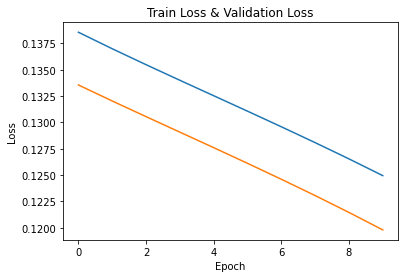

In [43]:
make_dir(PATH_VALIDATION)
make_dir(PATH_GRAPH)
net,train_loss,validation_loss = train(net, trainLoader,validationLoader, NUM_EPOCHS,PATH_VALIDATION)
plt.figure()
plt.plot(train_loss)
plt.plot(validation_loss)
plt.title('Train Loss & Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig(PATH_GRAPH+'/graph_loss_train_validation.png')

In [44]:
print("finalized")

finalized


TODO_ comentar

100%|██████████| 5/5 [00:00<00:00,  6.11it/s]


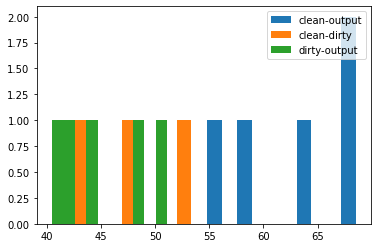

In [45]:
make_dir(PATH_TEST) 
net,pnsr_1_list,pnsr_2_list,pnsr_3_list = test_image_reconstruction(net, testLoader,PATH_TEST)
plt.hist(pnsr_1_list,  linewidth=1, label ='clean-output')
plt.hist(pnsr_2_list,  linewidth=1, label = 'clean-dirty')
plt.hist(pnsr_3_list, linewidth=1, label = 'dirty-output')
plt.legend(loc='upper right')
plt.savefig(PATH_GRAPH+'/graph_psnr.png')
plt.show()


In [46]:
print("finalized")

finalized


save model

In [47]:
make_dir(PATH_MODEL_SAVE) 
torch.save(net, PATH_MODEL_SAVE+'/model.pkl')


load model

100%|██████████| 5/5 [00:00<00:00, 157.37it/s]


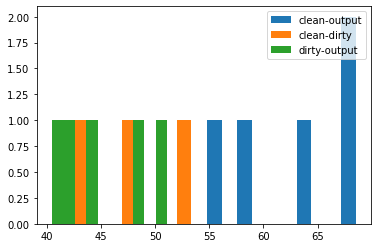

In [48]:
model = torch.load(PATH_MODEL_SAVE+'/model.pkl')
net,pnsr_1_list,pnsr_2_list,pnsr_3_list = test_image_reconstruction(net, testLoader,PATH_TEST)
plt.hist(pnsr_1_list,  linewidth=1, label ='clean-output')
plt.hist(pnsr_2_list,  linewidth=1, label = 'clean-dirty')
plt.hist(pnsr_3_list, linewidth=1, label = 'dirty-output')
plt.legend(loc='upper right')
plt.show()

# Resumen

**Image 28x28 & PSF Gauss 28x28**


**info image**: image size = 28x28, psf size = 28x28, type psf = gauss, dirty size = 28x28

In [49]:
display_psf(PATH_PSF_SAVE,TYPE_PSF)

NameError: name 'display_psf' is not defined

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

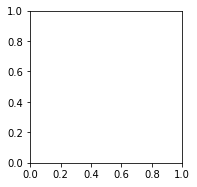

In [50]:
display_two(data_image[0],data_dirty[0],'image','dirty image')

**Info Dataset**:
size dataset = 10.000,
batch = 2,
train percentage = 70%,
validation percentage = 20%,
test percentage = 10%

**Info Neural Network**: number of epochs = 2, learning rate = 1e-3

In [ ]:
print(net)

**Info Results**

Train Loss vs Epoch

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.ylabel('Loss')

train Loss vs Epoch

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.title('Valid Loss')
plt.ylabel('Loss')

Train loss vs Test loss

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.plot(validation_loss)
plt.title('Train Loss vs Test Loss')
plt.ylabel('Loss')

pnsr - test

In [ ]:
plt.hist(pnsr_1_list,  linewidth=1, label ='clean-output')
plt.hist(pnsr_2_list,  linewidth=1, label = 'clean-dirty')
plt.hist(pnsr_3_list, linewidth=1, label = 'dirty-output')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Read image
clean = cv2.imread(PATH_TEST+'/clean'+str(10)+'.png')
dirty = cv2.imread(PATH_TEST+'/noisy'+str(10)+'.png')
output =  cv2.imread(PATH_TEST+'/denoised'+str(10)+'.png')
display(clean,'clean')
display(dirty,'dirty')
display(output,'output')